## Step 0: Setup

In [2]:
import sys
assert sys.version_info >= (3, 5)
import sklearn
assert sklearn.__version__ >= "0.20"
import numpy as np 
import os
%matplotlib inline
import matplotlib.pyplot as plt
np.random.seed(42)
import pandas as pd

## Step 1: Getting the data

Load in the dataset via Pandas from our Google Drive.

In [3]:
df = pd.read_csv(r"/Users/ryeo/dev/class/cs_m148/prostate_cancer_detection/Prostate_Cancer.csv")
prostate_data = df.drop("id", axis=1)

# We want to predict the diagnosis, so let's remove it
prostate_data_unlabeled = prostate_data.drop("diagnosis_result", axis=1)
prostate_data_unlabeled.head()

,radius,texture,perimeter,area,smoothness,compactness,symmetry,fractal_dimension
0,23,12,151,954,0.143,0.278,0.242,0.079
1,9,13,133,1326,0.143,0.079,0.181,0.057
2,21,27,130,1203,0.125,0.160,0.207,0.060
3,14,16,78,386,0.070,0.284,0.260,0.097
4,9,19,135,1297,0.141,0.133,0.181,0.059


## Step 2: Preprocessing the data

In [4]:
# This cell implements the complete pipeline for preparing the data

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder

from sklearn.base import BaseEstimator, TransformerMixin

class AugmentFeatures(BaseEstimator, TransformerMixin):

    '''
    implements the previous features we had defined
    housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
    housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
    housing["population_per_household"]=housing["population"]/housing["households"]
    '''

    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):

        return np.c_[X]


# Preprocessing for our numerical data
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', AugmentFeatures()),
        ('std_scaler', StandardScaler()),
    ])

# Preprocessing for our categorical data
cat_pipeline = Pipeline([
        ('ordinal_to_binary', OrdinalEncoder(categories=[['B', 'M']]))  # In case we use diagnosis as a feature
    ])


# Currently all our features are numerical
numerical_features = list(prostate_data_unlabeled)

# Currently none of our features are categorical (our label is, however)
categorical_features = []

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, numerical_features),
        ("cat", cat_pipeline, categorical_features),
    ])

# Create an instance of the housing data transformed with both its numerical data and categorical data
prostate_data_prepared = full_pipeline.fit_transform(prostate_data_unlabeled)

## Step 3: Training the model

In [5]:
from sklearn.model_selection import train_test_split

data_target = cat_pipeline.fit_transform(prostate_data["diagnosis_result"].to_numpy().reshape(-1, 1))

# Break the data points up into two sets: training and test
# Both sets consist of their predictor variable values (train, test) in addition to their response variable values (test, target_test)
train, test, target, target_test = train_test_split(prostate_data_prepared, data_target, test_size=0.3, random_state=0)

### Evaluate Hyperparameters

Find the optimal regularization hyperparameters for each linear/logistic model.

Best alpha for Lasso: 0.01 (score: 0.1256427513502865)


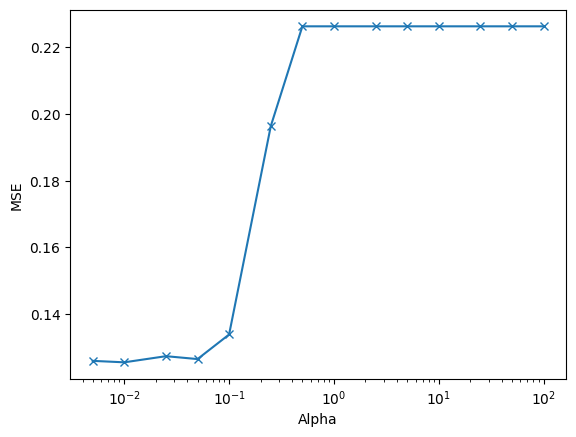

Best alpha for Ridge: 5 (score: 0.12384467616248755)


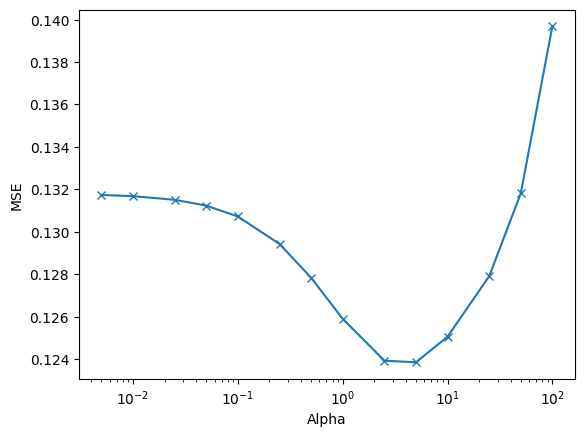

Best alpha for RidgeClassifier: 5 (score: 0.03333333333333333)


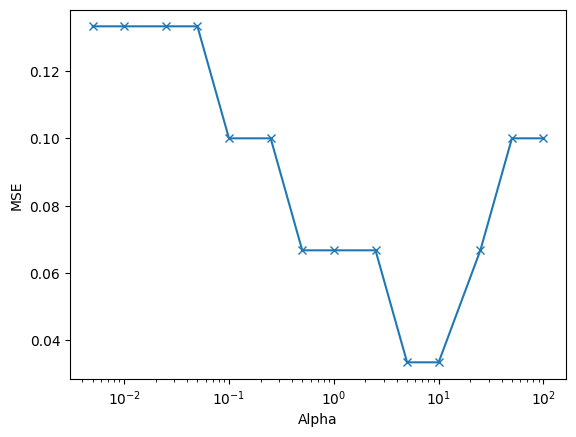

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
import warnings
from sklearn.linear_model import _sag

# Find optimal hyperparameter value for LASSO, Ridge, and RidgeClassifier
alphas = [0.005, 0.01, 0.025, 0.05, 0.1, 0.25, 0.5, 1, 2.5, 5, 10, 25, 50, 100]
best_alphas = []

for class_to_use, model_name in [(Lasso, "Lasso"), (Ridge, "Ridge"), (RidgeClassifier, "RidgeClassifier")]:
    scores = []

    # Try out each of the hyperparameters
    for i in alphas:

        # Initialize/Train selected model with specific hyperparameter for this iteration
        model = class_to_use(alpha=i)
        model.fit(train, target.ravel())

        # Record evaluation of this hyperparameter
        scores.append(mean_squared_error(target_test, model.predict(test)))

    print("Best alpha for", model_name + ":", alphas[scores.index(min(scores))], "(score:", str(min(scores)) + ")")
    best_alphas.append(alphas[scores.index(min(scores))])

    # Plot alpha values vs. resultant MSE
    plt.plot(alphas, scores, marker = 'x')
    plt.xlabel("Alpha")
    plt.xscale("log")
    plt.ylabel("MSE")
    plt.show()

# Elasticnet regularization is not guaranteed to converge, so suppress the myriad of warnings from finding the best L1 ratio
warnings.filterwarnings("ignore", category=_sag.ConvergenceWarning)

# Find optimal L1 ratio for logistic regression with elasticnet regularization
# NOTE: We need to iterate through the hyperparameters separately since it's a different set of hyperparameters
scores = []
min_mse = 2147483647
best_l1_ratio = 0
for ratio in range(1, 100):
    log_reg_elasticnet = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=(ratio / 100.0))
    log_reg_elasticnet.fit(train, target.ravel())
    mse = mean_squared_error(target_test, log_reg_elasticnet.predict(test))
    if (mse < min_mse):
        min_mse = mse
        best_l1_ratio = ratio / 100.0


### Train Models with Best Hyperparameters

In [7]:
# Fit linear regression with no regularization
lin_reg = LinearRegression()
lin_reg.fit(train, target)

# Fit LASSO regression according to optimal alpha value determined earlier
lasso = Lasso(alpha = best_alphas[0])
lasso.fit(train, target)

# Fit Ridge regression according to optimal alpha value determined earlier
ridge = Ridge(alpha = best_alphas[1])
ridge.fit(train, target)

# Fit Ridge classifier according to optimal alpha value determined earlier
ridge_clf = RidgeClassifier(alpha = best_alphas[2])
ridge_clf.fit(train, target.ravel())

# Fit logistic regression with no regularization and default solver
log_reg = LogisticRegression(penalty=None, solver='lbfgs')
log_reg.fit(train, target.ravel())

# Fit logistic regression with L1 regularization (mandates use of a different solver)
log_reg_L1 = LogisticRegression(penalty='l1', solver='liblinear')
log_reg_L1.fit(train, target.ravel())

# Fit logistic regression with L2 regularization and default solver
log_reg_L2 = LogisticRegression(penalty='l2', solver='lbfgs')
log_reg_L2.fit(train, target.ravel())

# Fit logistic regression with elasticnet regularization according to optimal L1 ratio determined earlier (mandates use of a different solver)
log_reg_elasticnet = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=best_l1_ratio)
log_reg_elasticnet.fit(train, target.ravel())

LogisticRegression(l1_ratio=0.01, penalty='elasticnet', solver='saga')

### Print Predictions vs Actual Labels

In [8]:
data = test
labels = target_test

# Print predictions vs. actual labels and MSE for each model that was trained
for model, title_string in [(lin_reg, "Linear Regression, no regularization:"),
                            (lasso, "Linear Regression, LASSO regularization, alpha = " + str(best_alphas[0]) + ":"),
                            (ridge, "Linear Regression, Ridge regularization, alpha = " + str(best_alphas[1]) + ":"),
                            (ridge_clf, "Linear Regression, Ridge classifier, alpha = " + str(best_alphas[2]) + ":"),
                            (log_reg, "Logistic Regression, no regularization:"),
                            (log_reg_L1, "Logistic Regression, L1 regularization:"),
                            (log_reg_L2, "Logistic Regression, L2 regularization:"),
                            (log_reg_elasticnet, "Logistic Regression, elasticnet regularization, l1_ratio = " + str(best_l1_ratio) + ":"),
                           ]:
    print(title_string)
    print("Predictions:", end = "\t")
    pred_list = model.predict(data)
    for pred in pred_list:
        if (isinstance(pred, float)):
            print(round(pred, 4), end = "\t")
        else:
            print(round(pred[0], 4), end = "\t")
    print()
    print("Actual labels:", end = "\t")
    for label in labels:
        print(label[0], end = "\t")
    print()
    print("MSE: ", mean_squared_error(target_test, pred_list))
    print()

Linear Regression, no regularization:
Predictions:	0.8831	0.6749	1.1656	0.1787	0.663	0.5501	0.4432	0.6224	0.5268	0.9771	0.9383	0.4314	1.6358	0.8151	0.5125	1.2202	1.0107	0.8354	1.1189	0.7433	0.6104	0.8959	0.4852	-0.0142	1.1084	0.5041	0.8571	0.5793	1.8058	0.346	
Actual labels:	1.0	1.0	1.0	0.0	1.0	0.0	1.0	1.0	1.0	1.0	1.0	0.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	0.0	1.0	0.0	1.0	1.0	1.0	0.0	
MSE:  0.13179387326174516

Linear Regression, LASSO regularization, alpha = 0.01:
Predictions:	0.8183	0.6037	1.0662	0.1996	0.6268	0.4832	0.4451	0.5691	0.497	0.9784	0.8929	0.3987	1.5894	0.737	0.5436	1.1316	0.9382	0.8073	1.0741	0.6856	0.5761	0.8316	0.6464	0.1126	1.0424	0.4231	0.8181	0.5532	1.7446	0.3787	
Actual labels:	1.0	1.0	1.0	0.0	1.0	0.0	1.0	1.0	1.0	1.0	1.0	0.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	0.0	1.0	0.0	1.0	1.0	1.0	0.0	
MSE:  0.1256427513502865

Linear Regression, Ridge regularization, alpha = 5:
Predictions:	0.8022	0.5836	1.0693	0.1876	0.6114	0.4908	0.4834	0.5674	0.5212	0.9513	0.

### ROC Curves for Optimal Models

Logistic Regression, no regularization
Accuracy:  0.8666666666666667
F1:  0.9166666666666666
Logistic Regression, L1 regularization
Accuracy:  0.9333333333333333
F1:  0.9565217391304348
Logistic Regression, L2 regularization
Accuracy:  0.9666666666666667
F1:  0.9787234042553191
Logistic Regression, elasticnet regularization, alpha = 0.01
Accuracy:  0.9666666666666667
F1:  0.9787234042553191


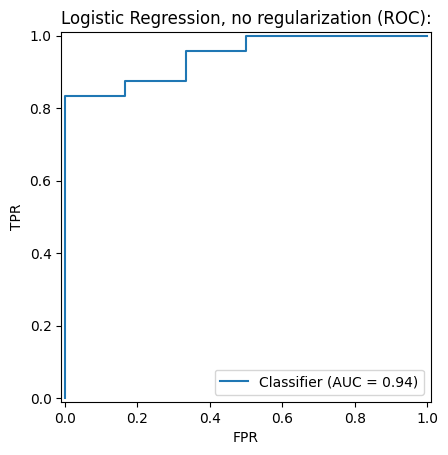

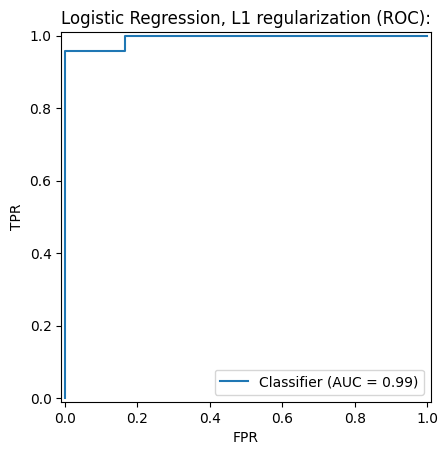

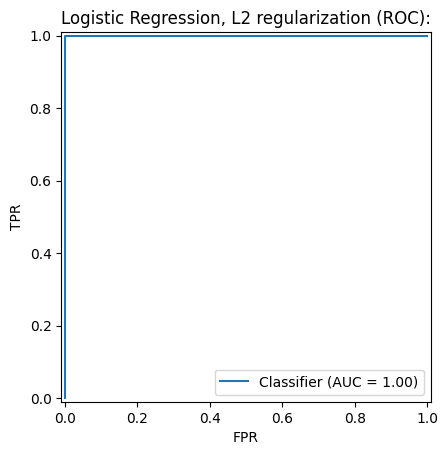

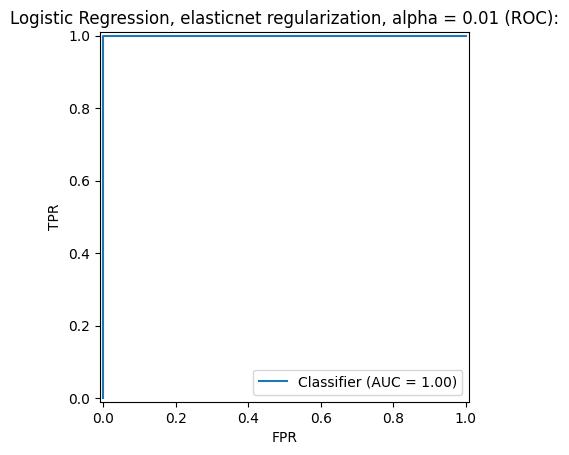

In [9]:
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

for model, title_string in [(log_reg, "Logistic Regression, no regularization"),
                            (log_reg_L1, "Logistic Regression, L1 regularization"),
                            (log_reg_L2, "Logistic Regression, L2 regularization"),
                            (log_reg_elasticnet, "Logistic Regression, elasticnet regularization, alpha = " + str(best_l1_ratio)),
                           ]:

    pred = model.predict(data)
    pred_prob = model.predict_proba(data)[:,1]

    RocCurveDisplay.from_predictions(labels, pred_prob)
    f1 = f1_score(labels, pred)
    acc = accuracy_score(labels, pred)

    plt.title(title_string + " (ROC):")
    plt.ylabel("TPR")
    plt.xlabel("FPR")

    print(title_string)
    print("Accuracy: ", acc)
    print("F1: ", f1)

Linear Regression, no regularization:
Accuracy:  0.8666666666666667
F1:  0.9166666666666666
Linear Regression, LASSO regularization, alpha = 0.01:
Accuracy:  0.9333333333333333
F1:  0.9565217391304348
Linear Regression, Ridge regularization, alpha = 5:
Accuracy:  0.9666666666666667
F1:  0.9787234042553191
Linear Regression, Ridge classifier, alpha = 5:
Accuracy:  0.9666666666666667
F1:  0.9787234042553191


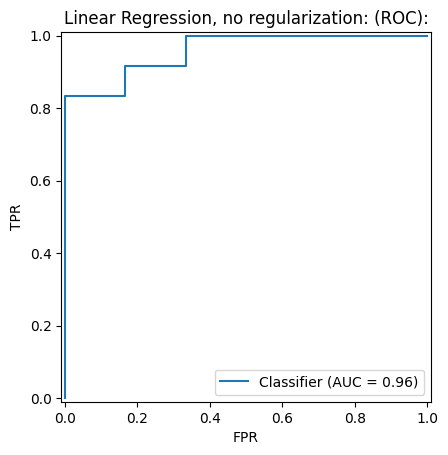

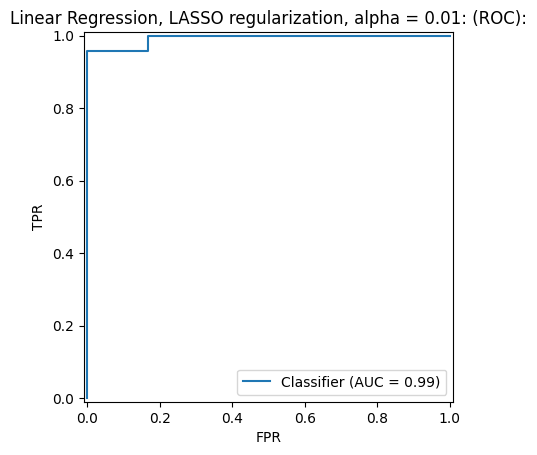

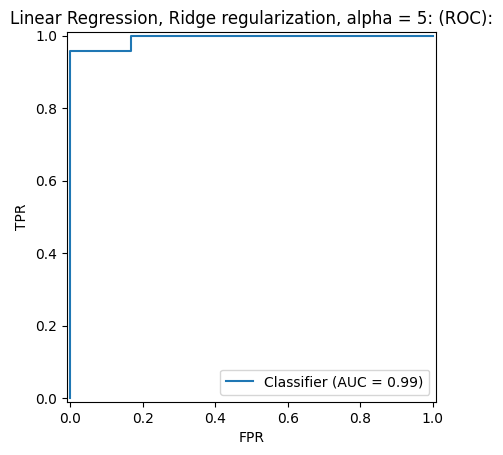

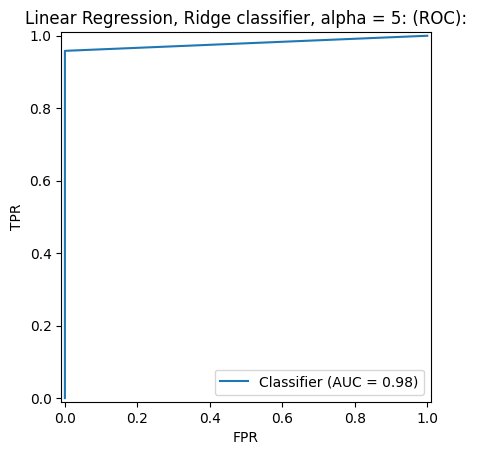

In [10]:
from sklearn.metrics import RocCurveDisplay

for model, title_string in [(lin_reg, "Linear Regression, no regularization:"),
                            (lasso, "Linear Regression, LASSO regularization, alpha = " + str(best_alphas[0]) + ":"),
                            (ridge, "Linear Regression, Ridge regularization, alpha = " + str(best_alphas[1]) + ":"),
                            (ridge_clf, "Linear Regression, Ridge classifier, alpha = " + str(best_alphas[2]) + ":")
                           ]:

    pred_prob = model.predict(data)
    pred = np.zeros_like(pred_prob)
    pred[pred_prob >= 0.5] = 1

    RocCurveDisplay.from_predictions(labels, pred_prob)

    f1 = f1_score(labels, pred)
    acc = accuracy_score(labels, pred)

    plt.title(title_string + " (ROC):")
    plt.ylabel("TPR")
    plt.xlabel("FPR")

    print(title_string)
    print("Accuracy: ", acc)
    print("F1: ", f1)

## Step 4: Analyze the results

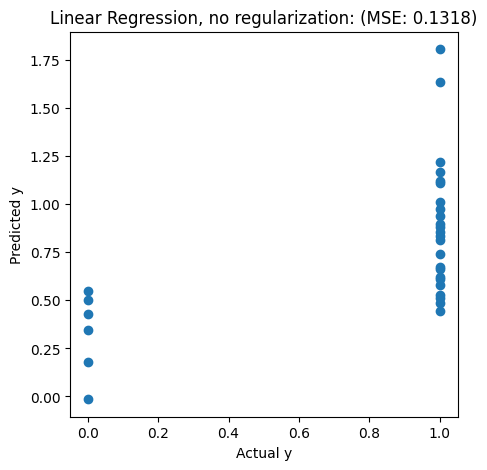

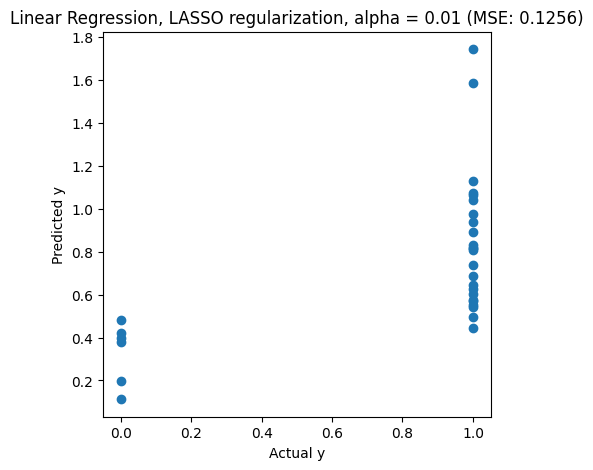

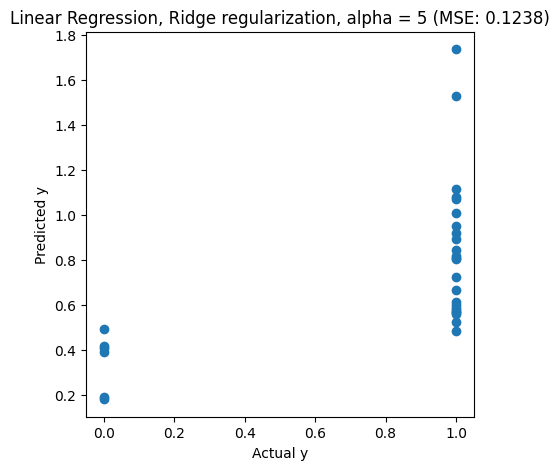

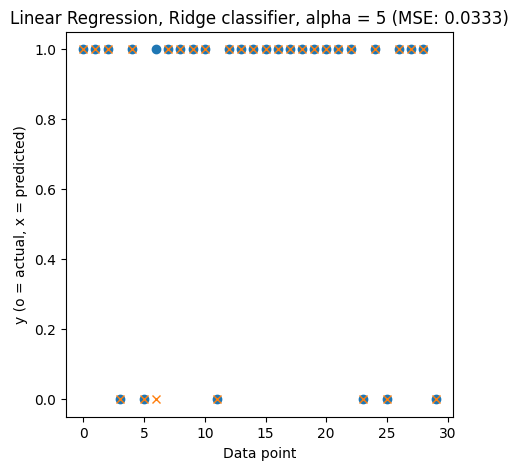

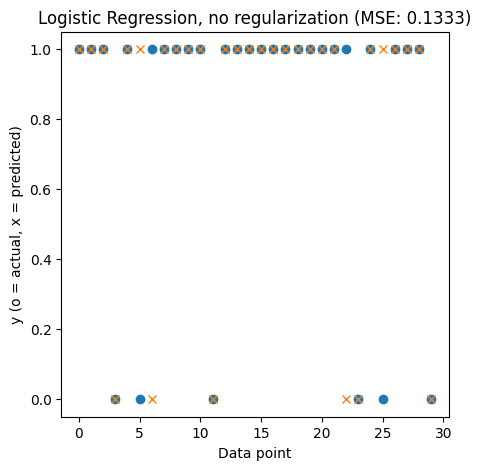

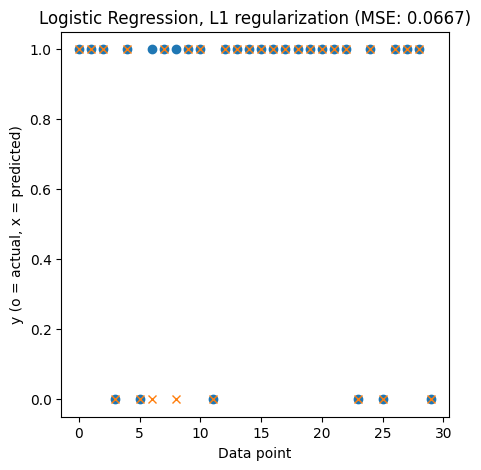

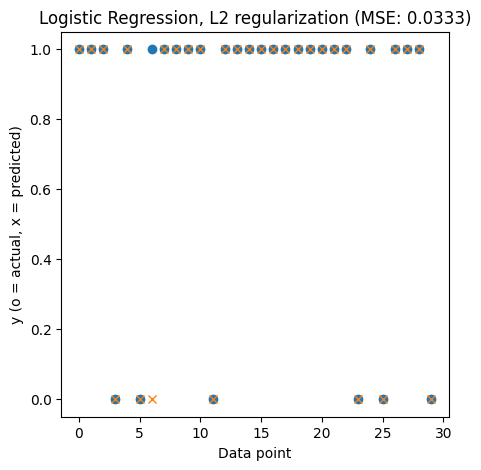

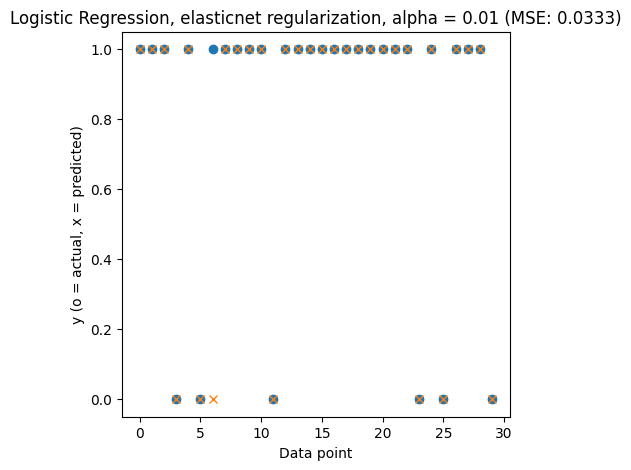

In [11]:
from sklearn.metrics import mean_squared_error

# Plot linear, lasso, and ridge regression on graphs which compare actual and predicted values of y
for model, title_string in [(lin_reg, "Linear Regression, no regularization:"),
                            (lasso, "Linear Regression, LASSO regularization, alpha = " + str(best_alphas[0])),
                            (ridge, "Linear Regression, Ridge regularization, alpha = " + str(best_alphas[1]))
                           ]:
    pred_list = model.predict(test)

    # Compute MSE just so we can show it in the title
    mse = mean_squared_error(target_test, pred_list)

    fig, ax = plt.subplots(1,1, figsize=(5,5))
    ax.plot(target_test, pred_list, 'o')
    grid = np.linspace(0, 1, 100)
    ax.set_title(title_string + " (MSE: " + str(round(mse, 4)) + ")")
    ax.set_xlabel("Actual y")
    ax.set_ylabel("Predicted y")

# Plot ridge classifier and logistic regression models on a graph which shows disparity for each point
for model, title_string in [(ridge_clf, "Linear Regression, Ridge classifier, alpha = " + str(best_alphas[2])),
                            (log_reg, "Logistic Regression, no regularization"),
                            (log_reg_L1, "Logistic Regression, L1 regularization"),
                            (log_reg_L2, "Logistic Regression, L2 regularization"),
                            (log_reg_elasticnet, "Logistic Regression, elasticnet regularization, alpha = " + str(best_l1_ratio)),
                           ]:
    pred_list = model.predict(test)

    # Compute MSE just so we can show it in the title
    mse = mean_squared_error(target_test, pred_list)

    fig, ax = plt.subplots(1,1, figsize=(5,5))
    ax.plot(range(len(target_test)), target_test, 'o')
    ax.plot(range(len(pred_list)), pred_list, 'x')
    grid = np.linspace(0, 1, 100)
    ax.set_title(title_string + " (MSE: " + str(round(mse, 4)) + ")")
    ax.set_xlabel("Data point")
    ax.set_ylabel("y (o = actual, x = predicted)")